<a href="https://colab.research.google.com/github/Qb2000/NTHU_2023_DLBOI_HW/blob/main/report/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Report
</div>


In [ ]:
# Download train and val dataset
!wget -q -O report_train.npy "https://www.dropbox.com/scl/fi/30dlbblp7wytcvoy05col/report_train.npy?rlkey=jx100qoz5n1d654v2mi32i9aj&dl=1"
!wget -q -O report_val.npy "https://www.dropbox.com/scl/fi/oo6g1yqhbjm22wffeddgv/report_val.npy?rlkey=9rqe0rucjhrbzv3x7xbs5047z&dl=1"

## A. Data Loading and Preprocessing

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

# Load Dataset
x_train = np.transpose(np.load('report_train.npy'), (0, 3, 1, 2))
x_val = np.transpose(np.load('report_val.npy'), (0, 3, 1, 2))

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')

num_classes = 6

# Create labels
y_train = np.concatenate([np.full(425, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(100, i) for i in range(num_classes)])

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

Shape of x_train: (2550, 3, 150, 150)
Shape of x_val: (600, 3, 150, 150)


In [ ]:
batch_size = 32

dataarg = 0

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Number of samples in train and validation are 2550 and 600.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


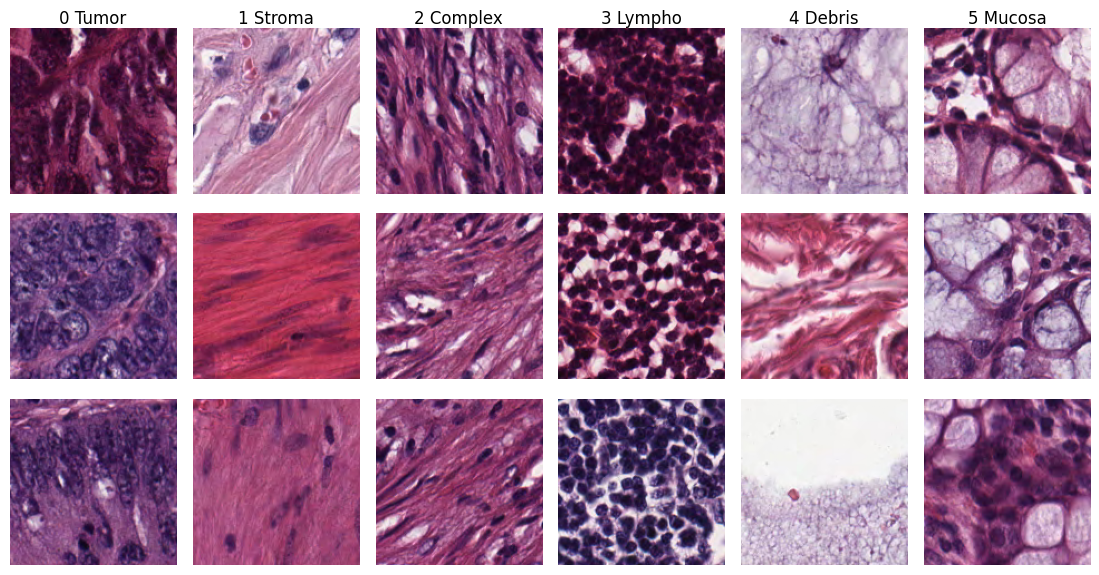

In [ ]:
import matplotlib.pyplot as plt
import random

class_names = ['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa']

num_classes = 6
samples_per_class = 3

fig, axes = plt.subplots(samples_per_class, num_classes, figsize=(12, 6))

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.1)

for class_idx in range(num_classes):
    indices_of_class = np.where(y_train == class_idx)[0]
    random_indices = random.sample(list(indices_of_class), samples_per_class)

    for i in range(samples_per_class):
        ax = axes[i, class_idx]
        img = x_train[random_indices[i]].numpy().transpose((1, 2, 0))
        img = img / img.max()
        ax.imshow(img)
        ax.axis('off')

        if i == 0:
            ax.set_title(f'{class_idx} {class_names[class_idx]}', pad=3)

plt.show()

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_transforms = transforms.Compose(
    [
        transforms.Resize((150, 150)),
        # transforms.RandAugment(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=45),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
    ]
)

class MedicalDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.Tensor(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.transform(Image.fromarray(self.x[idx].numpy().astype(np.uint8).transpose(1,2,0))), self.y[idx]

In [ ]:
batch_size = 32

dataarg=1

train_dataset = MedicalDataset(x_train, y_train, train_transforms)
val_dataset = MedicalDataset(x_val, y_val, train_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

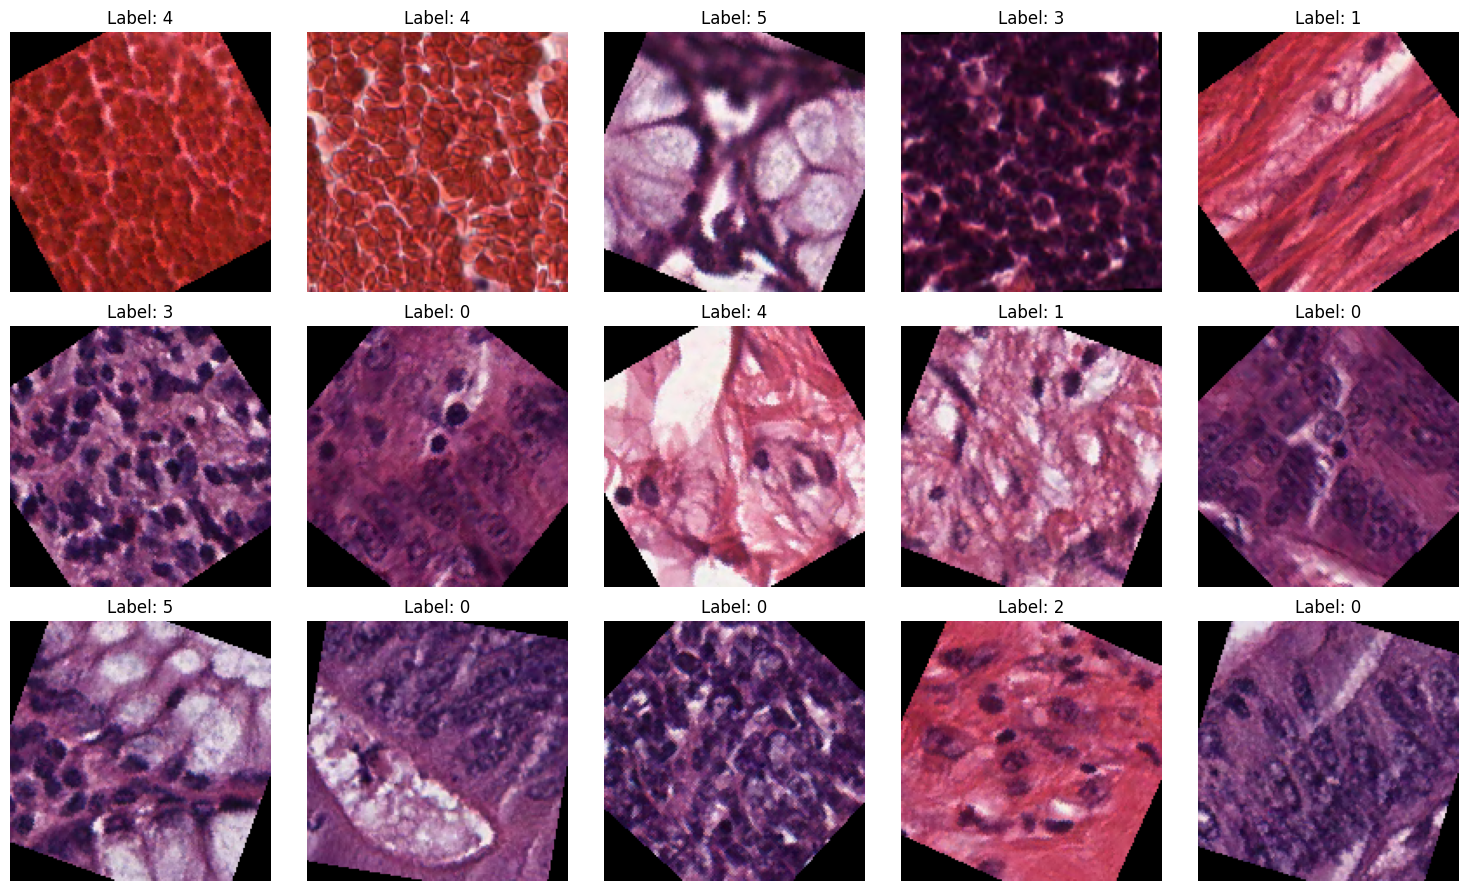

In [ ]:
import matplotlib.pyplot as plt
import random

# Define the grid size
rows, cols = 3, 5
fig, axes = plt.subplots(rows, cols, figsize=(15, 9))

# Flatten the axes array for easy iteration
axes = axes.ravel()

# Select random indices
random_indices = random.sample(range(len(train_dataset)), rows * cols)

for idx, ax in zip(random_indices, axes):
    image, label = train_dataset[idx]
    # Assumes the image tensor is in the format CxHxW and needs to be transposed to HxWxC
    ax.imshow(image.permute(1, 2, 0).numpy())
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## B. Defining Neural Networks

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

model = models.resnet18(weights='IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = True

num_ftrs = model.fc.in_features

model.classifier = nn.Sequential(nn.Linear(num_ftrs, 128),
      nn.BatchNorm1d(128),
      nn.ReLU(),
      nn.Linear(128, 6))

model = model.cuda()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## C. Training the Neural Network

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs =40

# Change you model here
# model = ConvGAP()
# print(model)
# model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)



for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, Train loss: 1.2393, Train acc: 70.67%, Val loss: 4.9331, Val acc: 16.67%, Best Val loss: 4.9331 Best Val acc: 16.67%
Epoch 2/40, Train loss: 0.5314, Train acc: 81.33%, Val loss: 0.4296, Val acc: 84.67%, Best Val loss: 0.4296 Best Val acc: 84.67%
Epoch 3/40, Train loss: 0.4154, Train acc: 84.47%, Val loss: 0.4259, Val acc: 83.83%, Best Val loss: 0.4259 Best Val acc: 84.67%
Epoch 4/40, Train loss: 0.3492, Train acc: 87.41%, Val loss: 0.6175, Val acc: 80.83%, Best Val loss: 0.4259 Best Val acc: 84.67%
Epoch 5/40, Train loss: 0.3329, Train acc: 88.27%, Val loss: 0.8259, Val acc: 72.67%, Best Val loss: 0.4259 Best Val acc: 84.67%
Epoch 6/40, Train loss: 0.3752, Train acc: 86.94%, Val loss: 24.3863, Val acc: 31.50%, Best Val loss: 0.4259 Best Val acc: 84.67%
Epoch 7/40, Train loss: 0.3554, Train acc: 87.06%, Val loss: 0.4014, Val acc: 83.67%, Best Val loss: 0.4014 Best Val acc: 84.67%
Epoch 8/40, Train loss: 0.2892, Train acc: 89.92%, Val loss: 0.4702, Val acc: 82.50%, Best Val l

### Visualizing model performance

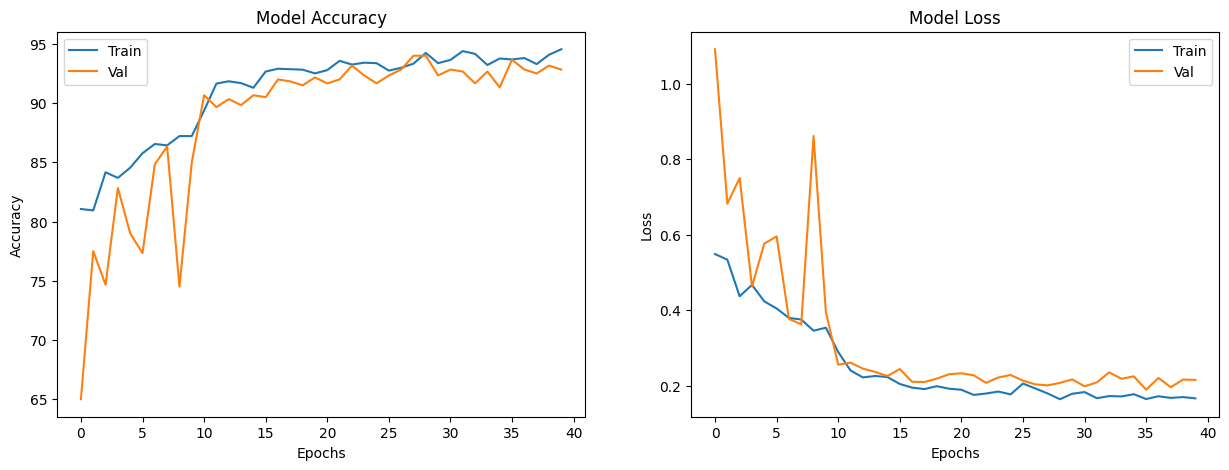

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Process Test Dataset

In [ ]:
# Download test dataset,
!wget -q -O report_test.npy "https://www.dropbox.com/scl/fi/ufcagx2cvjmervgqrgwrt/report_test.npy?rlkey=fijueom5x54628ivpzeki2bt0&dl=1"

In [ ]:
x_test = np.transpose(np.load('report_test.npy'), (0, 3, 1, 2))
print(f'Shape of x_test: {x_test.shape}')

y_test = np.concatenate([np.full(100, i) for i in range(num_classes)])

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

print(f'x_test: max value is {x_test.max().item()}, min value is {x_test.min().item()}, data type is {x_test.dtype}.')

batch_size = 32

# Combine the images and labels into a dataset

if dataarg == 1:
  test_dataset = MedicalDataset(x_test, y_test, val_transforms)
elif dataarg == 0:
  test_dataset = TensorDataset(x_test, y_test)
# Create a dataloader to load data in batches. Set batch size to 32.
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

Shape of x_test: (600, 3, 150, 150)
x_test: max value is 255.0, min value is 0.0, data type is torch.float32.


### Load Trained Model and Evaluate

In [ ]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        test_correct += (predicted.float() == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

Test accuracy is 91.66666666666667%
